## Setup

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import random
import time
import warnings
from datetime import datetime

import torch

import numpy as np

import matplotlib.pyplot as plt
from scripts.differentiable_pfn_evaluation import eval_model_range
from scripts.model_builder import get_model, get_default_spec, save_model, load_model
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, load_model_workflow_my

from scripts.model_configs import *

from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids
from priors.utils import plot_prior, plot_features
from priors.utils import uniform_int_sampler_f

from scripts.tabular_metrics import calculate_score_per_method, calculate_score
from scripts.tabular_evaluation import evaluate

from priors.differentiable_prior import DifferentiableHyperparameterList, draw_random_style, merge_style_with_info
from scripts import tabular_metrics
from notebook_utils import *

In [3]:
large_datasets = True
max_samples = 10000 if large_datasets else 5000
bptt = 10000 if large_datasets else 3000
suite='cc'

In [4]:
device = 'cuda'
base_path = '.'
max_features = 100

In [5]:
def print_models(model_string):
    print(model_string)

    for i in range(80):
        for e in range(50):
            exists = Path(os.path.join(base_path, f'smote+sq_models_diff_添加参数设置/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt')).is_file()
            if exists:
                print(os.path.join(base_path, f'smote+sq_models_diff_添加参数设置/prior_diff_real_checkpoint{model_string}_n_{i}_epoch_{e}.cpkt'))
        print()

In [6]:
'''
def train_function(config_sample, i, add_name=''):
    torch.cuda.empty_cache()
    start_time = time.time()
    N_epochs_to_save = 10
    
    
    # 经过本人更改的代码
    def save_callback(model, epoch):
        if not hasattr(model, 'last_saved_epoch'):
            model.last_saved_epoch = 0
        # 每1个批次保存一个模型
        if epoch % 1 == 0:
            config_sample['epoch_in_training'] = epoch
            save_model(model, base_path, f'my_models_diff/prior_diff_real_checkpoint{add_name}_n_{i}_epoch_{epoch}.cpkt',
                            config_sample)
            model.last_saved_epoch = model.last_saved_epoch + 1 # TODO: Rename to checkpoint
    
    model = get_model(config_sample
                      , device
                      , should_train=True
                      , verbose=1
                      , epoch_callback = save_callback)
    
    return
'''

"\ndef train_function(config_sample, i, add_name=''):\n    torch.cuda.empty_cache()\n    start_time = time.time()\n    N_epochs_to_save = 10\n    \n    \n    # 经过本人更改的代码\n    def save_callback(model, epoch):\n        if not hasattr(model, 'last_saved_epoch'):\n            model.last_saved_epoch = 0\n        # 每1个批次保存一个模型\n        if epoch % 1 == 0:\n            config_sample['epoch_in_training'] = epoch\n            save_model(model, base_path, f'my_models_diff/prior_diff_real_checkpoint{add_name}_n_{i}_epoch_{epoch}.cpkt',\n                            config_sample)\n            model.last_saved_epoch = model.last_saved_epoch + 1 # TODO: Rename to checkpoint\n    \n    model = get_model(config_sample\n                      , device\n                      , should_train=True\n                      , verbose=1\n                      , epoch_callback = save_callback)\n    \n    return\n"

In [7]:
def train_function(config_sample, i, add_name=''):
    torch.cuda.empty_cache()
    start_time = time.time()
    max_saved_models = 50  # 保持最多保存 50 个模型
    
    # 定义保存模型的回调函数
    def save_callback(model, epoch):
        # 仅保存第 91 到第 130 个 epoch 的模型
        if epoch < 91 or epoch > 130:
            return  # 跳过第 101 到第 150 以外的 epoch，不保存模型
        
        if not hasattr(model, 'last_saved_epoch'):
            model.last_saved_epoch = 0

        # 保存当前模型
        config_sample['epoch_in_training'] = epoch
        save_path = f'smote+sq_models_diff_添加参数设置/prior_diff_real_checkpoint{add_name}_n_{i}_epoch_{epoch}.cpkt'
        save_model(model, base_path, save_path, config_sample)
        model.last_saved_epoch += 1  # 更新保存次数
        
        # 获取当前已保存的模型列表
        saved_models = sorted(
            [file for file in os.listdir("smote+sq_models_diff_添加参数设置") if file.startswith(f"prior_diff_real_checkpoint{add_name}_n_{i}_")],
            key=lambda x: int(x.split('_epoch_')[-1].split('.cpkt')[0])  # 按 epoch 排序
        )
        
        # 保持最多保存 50 个模型，删除最早的模型
        if len(saved_models) > max_saved_models:
            oldest_model = saved_models[0]
            os.remove(os.path.join("smote+sq_models_diff_添加参数设置", oldest_model))  # 删除最早的模型文件
    
    # 初始化并训练模型
    model = get_model(config_sample, device, should_train=True, verbose=1, epoch_callback=save_callback)
    
    return

## Define prior settings

In [8]:
def reload_config(config_type='causal', task_type='multiclass', longer=0, apply_smote=False, use_sequential_attention=False):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'], config['differentiable'], config['flexible'] = 'prior_bag', True, True
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    # 新增SMOTE和顺序注意力参数
    config['apply_smote'] = apply_smote
    config['use_sequential_attention'] = use_sequential_attention
    
    return config, model_string

## Visualize Prior samples

In [9]:
config, model_string = reload_config(longer=1, apply_smote=True, use_sequential_attention=True)

config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']

config['multiclass_type'] = 'rank'
del config['differentiable_hyperparameters']['multiclass_type']

config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = .2 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .1 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = False # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = False

    
config['aggregate_k_gradients'] = 8
config['batch_size'] = 16*config['aggregate_k_gradients']
config['num_steps'] = 1024//config['aggregate_k_gradients']
config['epochs'] = 130
config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True

config_sample = evaluate_hypers(config)

In [10]:
config_sample

{'lr': 0.00011436505151849849,
 'dropout': 0.0,
 'emsize': 512,
 'batch_size': 128,
 'nlayers': 12,
 'num_features': 100,
 'nhead': 4,
 'nhid_factor': 2,
 'bptt': 1152,
 'eval_positions': None,
 'seq_len_used': 50,
 'sampling': 'normal',
 'epochs': 130,
 'num_steps': 128,
 'verbose': False,
 'mix_activations': False,
 'pre_sample_causes': True,
 'multiclass_type': 'rank',
 'nan_prob_unknown_reason_reason_prior': 0.5,
 'categorical_feature_p': 0.2,
 'nan_prob_no_reason': 0.0,
 'nan_prob_unknown_reason': 0.0,
 'nan_prob_a_reason': 0.0,
 'max_num_classes': 10,
 'num_classes': <function priors.utils.<lambda>.<locals>.<lambda>()>,
 'noise_type': 'Gaussian',
 'balanced': False,
 'normalize_to_ranking': False,
 'set_value_to_nan': 0.1,
 'normalize_by_used_features': True,
 'num_features_used': {'uniform_int_sampler_f(3,max_features)': <function tabpfn.priors.utils.<lambda>.<locals>.<lambda>()>},
 'num_categorical_features_sampler_a': -1.0,
 'differentiable_hyperparameters': {'prior_bag_exp_we

## Training

Using style prior: True
epoch:130
steps_per_epoch:1024
batch_size:16
aggregate_k_gradients:8
梯度下降的batch_size:128
num_datasets:2129920
train_mixed_precision:True
Using cuda device
Using a Transformer with 25.82 M parameters
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 281.17s | mean loss  2.25 | pos losses  2.28, 2.29,  nan, 2.26,  nan, 2.26, 2.28, 2.27, 2.26, 2.27,  nan, 2.32, 2.28, 2.27,  nan, 2.27, 2.27, 2.17, 2.21,  nan, 2.27,  nan, 2.26, 2.27,  nan, 2.13, 2.26,  nan, 2.25, 2.28, 2.31, 2.27,  nan, 2.26,  nan,  nan,  nan, 2.27, 2.28, 2.27, 2.24,  nan,  nan,  nan, 2.27, 2.30,  nan,  nan,  nan,  nan, 2.29, 2.30,  nan,  nan, 2.27,  nan, 2.27, 2.22, 2.29, 2.26, 2.28,  nan, 2.24, 2.23,  nan,  nan, 2.27, 2.27,  nan, 2.17, 2.28,  nan, 2.26, 2.29, 2.11, 2.29,  nan, 2.28, 2.31, 2.27, 2.27,  nan,  nan,  nan,  nan,  nan,  nan, 2.26, 2.18, 2.27, 2.27,  nan, 2.30, 2.31,  nan,  nan, 2.26, 2.27, 2.25,  nan, 2.28, 2.29,  nan, 2.

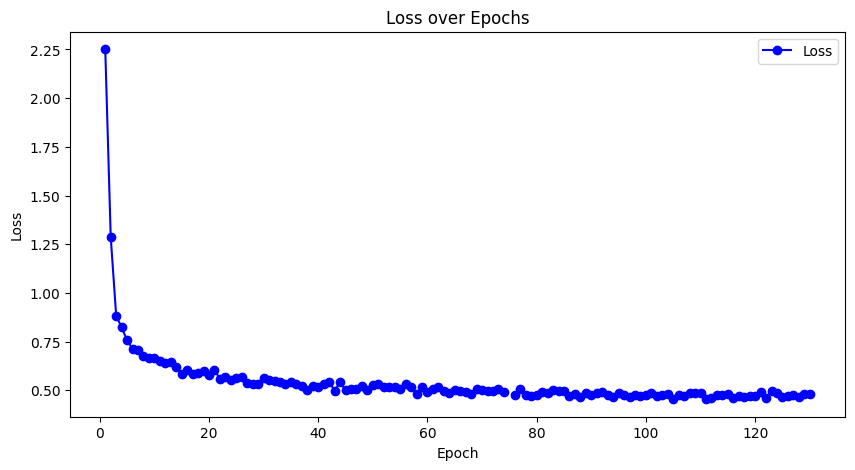

In [11]:
train_function(config_sample, 1, add_name='')